In [2]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
# IMPLEMENTATION OF THE FRANK-WOLFE ALGORITHM
# In this file, we define the functions required for the implementation of the algorithm.


### Frank-Wolfe 算法求解 Lasso 问题：

1. 定义函数 $f(x, A, y)$:
$$
f(x) = |Ax-y|^2
$$
见代码 def f(x, A, y)

2. 定义函数的梯度 $∇f(x, A, y)$:
$$
∇f(x) = 2AT(Ax−y)
$$

3. Oracle 步骤:
$$
s=\arg\min_{y\in D}\langle\nabla f(x_k),y-x_k\rangle 
$$
其实就是找 $∇f(x)$ 中绝对值最大的元素, 见代码 fwOracle.

4. update 步骤:
$$
x_{k+1}=(1-\rho_k)x_k+\rho_ks
$$

In [3]:
# %% Define the function f(x)
def f(x, A, y):
    """
    Function that computes the f(x) defined as: |Ax - y|^2
    :param x: (p, 1) numpy vector
                Data vector
    :param A: (n, p) numpy matrix
                Design matrix of the LASSO problem
    :param y: (n, ) numpy vector
                Target vector of the LASSO problem
    :return: f(x), scalar, evaluated as defined above
    """
    return np.matmul((np.matmul(A, x) - y).transpose(), np.matmul(A, x) - y)


# %% Define function to compute gradient
def gradient(x, A, y):
    """
    Function that computes the gradient of f(x) defined as: 2 * (A.T(Ax - y))
    :param x: same as defined in previous function
    :param A: same as defined in previous function
    :param y: same as defined in previous function
    :return:
    """
    return 2 * np.matmul(A.transpose(), np.matmul(A, x) - y)

求解 Lasso 问题，一般需要正则化:
$$
loss = loss + l|x|
$$

In [4]:
# %% Define function to find a point in the Oracle
def fwOracle(gradient, l):
    """
    Function that computes the Frank-Wolfe Oracle defined as:
        argmin(s) <gradient(f(x)), s> where s in the feasible
        set D and < > is the inner product.
    :param gradient: (p, 1) numpy vector
                Should be the gradient of f(x)
    :param l: (lambda) a scalar > 0
                Penalty parameter of the LASSO problem
    :return: s: (p, 1) numpy vector
                FW Oracle as defined above
    """
    # Initialize the zero vector
    s = np.zeros((p, 1))

    # Check if all coordinates of x are 0
    # If they are, then the Oracle contains zero vector
    if (gradient != 0).sum() == 0:
        return s

    # Otherwise, follow the following steps
    else:
        # Compute the (element-wise) absolute value of x
        a = abs(gradient)
        # Find the first coordinate that has the maximum absolute value
        i = np.nonzero(a == max(a))[0][0]
        # Compute s
        s[i] = - np.sign(gradient[i]) * l
        return s

## xk+1 = xk + grad(f(xk))      grad(f) = [g1,g2,...,gn]    假设 gi 最大 s = [0,0,...., gi,..,0]
## xk+1 = xk + s


#%% Define function for applying the Frank-Wolfe algorithm to solve LASSO problem
def frankWolfeLASSO(A, y, l=500, tol=0.0001, K=15000):
    """
    Function that applies the Frank-Wolfe algorithm on a LASSO problem, given
    the required x, A, y and K.
    :param A: (n, p) numpy matrix
                Design matrix of the LASSO problem
    :param y: (n, ) numpy vector
                Target vector of the LASSO problem
    :param K: integer > 0
                Maximum number of iterations
    :param l: integer > 0
                Regularization parameter
    :param tol: float > 0
                    Tolerance rate of the error ||f(x_k) - f(x_(k-1))||
    :return: data: f(x): K-dimensional numpy vector
                argmin(D) of f
            diffx: (K-1)-dimensional numpy vector
                difference ||f(x_k) - f(x_(k-1))||
            k: integer > 0
                The number of iterations made
    """
    # Initialise:
    # x : sequence of K data points
    #       (each being a p-dimensional vector of features)
    # s : sequence of K "oracles"
    #       (each being a p-dimensional vector)
    # rho : step-size sequence having K elements
    # data : K-dimensional vector of resulting data points
    # data : (K-1)-dimensional vector of the difference f(x_k) - f(x_(k-1))
    # x[0] and s[0] to p-dimensional vectors of zeros (starting points)
    x = [None] * K
    s = [None] * K
    rho = [None] * K
    data = [None] * K
    diffx = [None] * K
    p = np.shape(A)[1]
    x[0] = np.zeros((p, 1))
    s[0] = np.zeros((p, 1))

    # Apply the Frank-Wolfe Algorithm
    for k in range(1, K):
        rho[k] = 2 / (2 + k)
        s[k] = fwOracle(gradient(x[k - 1], A, y), l)
        x[k] = (1 - rho[k]) * x[k - 1] + rho[k] * s[k]
        data[k] = f(x[k], A, y)
        if k > 1:
            diffx[k - 1] = data[k] - data[k - 1]
            if tol >= abs(diffx[k - 1]): break

    # Return
    return data, diffx, k

In [5]:
dataToPlot = pd.DataFrame({
    "epsilon" : np.array([0.1, 0.01, 0.001, 0.0001]),
    "k1" : np.zeros(4),
    "k2" : np.zeros(4),
    "k3" : np.zeros(4)
})

# CASE 1: l = 50, n = 1000, p = 700
# Array that will hold the returned numbers of iterations for each level of 
# tolerance.
returnedK = np.zeros(4)
# Array that will hold the returned data (f(x))
data = [None] * 4
# Array that will hold the norm of the difference: ||f(x_k) - (f_(k-1))
diffx = [None] * 4
n = 1000  # number of observations
p = 700   # number of parameters
l = 50    # penalty parameter
A, y = datasets.make_regression(n, p)
y = y.reshape((n, 1))

0
1
2
3


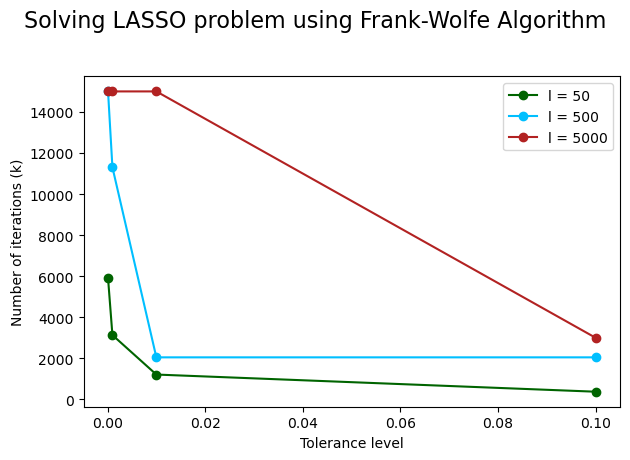

In [6]:
#%% First round of testing of our implementation:
# We fix the number of obseverations (n) and the number of parameters (p)
# and study the performance of the algorithm when only lambda (l) is changing.

# Array holding the tolerance levels we will be working with
epsilon = np.array([0.1, 0.01, 0.001, 0.0001])

# Pandas dataframe that will hold the data used to create the plot
dataToPlot = pd.DataFrame({
    "epsilon" : np.array([0.1, 0.01, 0.001, 0.0001]),
    "k1" : np.zeros(4),
    "k2" : np.zeros(4),
    "k3" : np.zeros(4)
})

# CASE 1: l = 50, n = 1000, p = 700
# Array that will hold the returned numbers of iterations for each level of 
# tolerance.
returnedK = np.zeros(4)
# Array that will hold the returned data (f(x))
data = [None] * 4
# Array that will hold the norm of the difference: ||f(x_k) - (f_(k-1))
diffx = [None] * 4
n = 1000  # number of observations
p = 700   # number of parameters
l = 50    # penalty parameter
A, y = datasets.make_regression(n, p)
y = y.reshape((n, 1))

#print("case 1:-------------------------------------------")
for i in range(4):
    print(i)
    data[i], diffx[i], dataToPlot.loc[i, 'k1'] = \
      frankWolfeLASSO(A, y, l=50, tol=epsilon[i])


# CASE 2: l = 500, n = 1000, p = 700
returnedK = np.zeros(4)
data = [None] * 4
diffx = [None] * 4
n = 1000
p = 700
l = 500
A, y = datasets.make_regression(n, p)
y = y.reshape((n, 1))

#print("case 2:-------------------------------------------")
for i in range(4):
    print(i)
    data[i], diffx[i], dataToPlot.loc[i, 'k2'] = \
        frankWolfeLASSO(A, y, l=l, tol=epsilon[i])


# CASE 3: l = 5000, n = 1000, p = 700
returnedK = np.zeros(4)
data = [None] * 4
diffx = [None] * 4
n = 1000
p = 700
l = 5000
A, y = datasets.make_regression(n, p)
y = y.reshape((n, 1))

#print("case 3:-------------------------------------------")
for i in range(4):
    print(i)
    data[i], diffx[i], dataToPlot.loc[i, 'k3'] = \
        frankWolfeLASSO(A, y, l=l, tol=epsilon[i])

# Plot the results
plt.plot(dataToPlot.epsilon, dataToPlot.k1, marker="o", color="darkgreen",\
              label = "l = 50")
plt.plot(dataToPlot.epsilon, dataToPlot.k2, marker="o", color="deepskyblue", \
              label = "l = 500")
plt.plot(dataToPlot.epsilon, dataToPlot.k3, marker="o", color="firebrick", \
              label = "l = 5000")
plt.legend()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Solving LASSO problem using Frank-Wolfe Algorithm", fontsize=16)
plt.xlabel("Tolerance level")
plt.ylabel("Number of iterations (k)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("Question6b_toleranceIterations_l.png")
plt.show()


In [15]:
dataToPlot

,epsilon,k1,k2,k3
0,0.1000,369.0,2043.0,2996.0
1,0.0100,1205.0,2043.0,14999.0
2,0.0010,3128.0,11301.0,14999.0
3,0.0001,5905.0,14999.0,14999.0
